In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [43]:
%tensorflow_version 1.x
import tensorflow as tf 
tf.__version__
import numpy as np
import pandas as pd
import os
import string
from string import digits
import matplotlib.pyplot as plt
# %matplotlib inline
import re
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model

In [44]:
# LOADING DATA 
data_path = "drive/MyDrive/dataset/spoc-train.tsv"
def read_data(data_path):
    data = pd.read_csv(data_path, sep="\t")
    # data.head()
    return data 

data = read_data(data_path)
data.shape


(54, 2)

In [45]:
# PREPROCESSING
def preprocess_data(data, sampleCount):
    # dropping unnecessary columns 
    # data = data.drop(['workerid', 'probid', 'subid', 'line', 'indent'], axis=1)

    # dropping rows with NaN values 
    countNaN = pd.isnull(data).sum()
    print("Rows with NaN values: ", countNaN)
    df = data.dropna(axis=0, how="any")
    # df.head()
    lines = df

    # picking random sample of length 
    lines=lines.sample(n=sampleCount,random_state=42)

    # lowercasing all characters
    lines['text']=lines['text'].apply(lambda x: x.lower())
    lines['code']=lines['code'].apply(lambda x: x.lower())

    # removing extra spaces
    lines['text']=lines['text'].apply(lambda x: x.strip())
    lines['code']=lines['code'].apply(lambda x: x.strip())
    
    # removing semicolon
    lines['text']=lines['text'].apply(lambda x: re.sub(";", " ", x))
    lines['code']=lines['code'].apply(lambda x: re.sub(";", " ", x))

    # removing brackets 
    lines['text']=lines['text'].apply(lambda x: re.sub("[\[({})\]]", " ", x))
    lines['code']=lines['code'].apply(lambda x: re.sub("[\[({})\]]", " ", x))

    lines['text']=lines['text'].apply(lambda x: re.sub(" +", " ", x))
    lines['code']=lines['code'].apply(lambda x: re.sub(" +", " ", x))

    # adding start and end tokens to target sequences
    lines['code'] = lines['code'].apply(lambda x : 'START_ '+ x + ' _END')


    # fetching all the distinct words in text and code columns 
    text_words = set()
    for text_word in lines['text']:
        for word in text_word.split():
            if word not in text_words:
                text_words.add(word)
        
    code_words = set()
    for code_word in lines['code']:
        for word in code_word.split():
            if word not in code_words:
                code_words.add(word)

    lines['text_length']=lines['text'].apply(lambda x:len(x.split(" ")))
    lines['code_length']=lines['code'].apply(lambda x:len(x.split(" ")))

    # lines[lines['text_length']<=20].shape, lines[lines['code_length']<=20].shape

    # clipping to 20 length
    lines=lines[lines['text_length']<=20]
    lines=lines[lines['code_length']<=20]

    print("maximum length of codes ",max(lines['code_length']))
    print("maximum length of texts ",max(lines['text_length']))

    max_length_src=max(lines['text_length'])
    max_length_tar=max(lines['code_length'])

    input_words = sorted(list(text_words))
    target_words = sorted(list(code_words))
    num_encoder_tokens = len(text_words)
    num_decoder_tokens = len(code_words)
    num_encoder_tokens, num_decoder_tokens

    num_decoder_tokens += 1 #for zero padding

    # indexing all the tokens for all the codes and texts 
    input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
    target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

    lines = shuffle(lines)
    lines.head(10)

    return lines, max_length_src, max_length_tar, input_token_index, target_token_index, num_encoder_tokens, num_decoder_tokens

lines, max_length_src, max_length_tar, input_token_index, target_token_index, num_encoder_tokens, num_decoder_tokens = preprocess_data(data, 54)

Rows with NaN values:  text    0
code    0
dtype: int64
maximum length of codes  12
maximum length of texts  9


In [46]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [47]:
# Splitting into training and test set  
X, y = lines['text'], lines['code']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1,random_state=42)
print("shape of train and test ", X_train.shape, X_test.shape)

shape of train and test  (48,) (6,)


In [48]:
def generate_batch(X = X_train, y = y_train, batch_size = 2):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            # one hot encoding 
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] 
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] 
                    if t>0:
                        # print("decoder_target_data[",i,t-1,target_token_index[word],"]")
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)        # yielding one hot encoded data


In [49]:
latent_dim=300

In [50]:
# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)

encoder_lstm = LSTM(latent_dim, return_state=True)      
# return_state is set to True so that the last layer of encoder returns the output to the first layer of decoder  

encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]     # hidden state and cell state


In [51]:
# Decoder
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
# return_sequences and return_states are kept true so that the output of decoder states are captured 

decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [52]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [53]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, None, 300)    20100       input_7[0][0]                    
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, None, 300)    25500       input_8[0][0]                    
____________________________________________________________________________________________

In [54]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 2
epochs = 4

In [57]:
history = model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

Epoch 1/4
24/24 [==============================] - 4s 177ms/step - loss: 1.7681 - val_loss: 1.5448
Epoch 2/4
24/24 [==============================] - 1s 39ms/step - loss: 1.4614 - val_loss: 1.4553
Epoch 3/4
24/24 [==============================] - 1s 39ms/step - loss: 1.2574 - val_loss: 1.3811
Epoch 4/4
24/24 [==============================] - 1s 40ms/step - loss: 1.0746 - val_loss: 1.1663


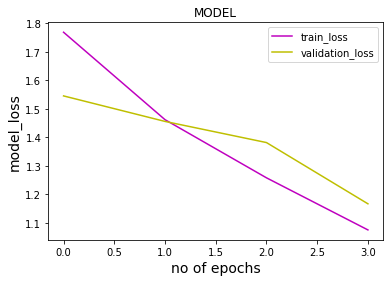

In [58]:
import matplotlib.pyplot as plt 

plt.plot(history.history['loss'], c="m")
plt.plot(history.history['val_loss'], c="y")
plt.legend(["train_loss", "validation_loss"])
plt.title("MODEL")
plt.xlabel("no of epochs", fontsize=14)
plt.ylabel("model_loss", fontsize=14)
plt.show()

In [59]:
# Encode input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [60]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [61]:
model.save("model.h5")

In [64]:
test_gen = generate_batch(X_test, y_test, batch_size = 1)
k=-1

In [65]:
while k<5:
    k+=1
    (input_seq, actual_output), _ = next(test_gen)
    decoded_sentence = decode_sequence(input_seq)
    print('input pseudocode:', X_test[k:k+1].values[0])
    print('actual c code:', y_test[k:k+1].values[0][6:-4])
    print('predicted c code:', decoded_sentence[:-4])
    print()


input pseudocode: read num3
actual c code:  scanf "%d", &num3  
predicted c code:  scanf "%d", 

input pseudocode: result = radius * radius * 22 / 7
actual c code:  result = radius * radius * 22 / 7  
predicted c code:  result = * * * * * 

input pseudocode: print result
actual c code:  printf "%d\n", result  
predicted c code:  printf "enter 

input pseudocode: print enter third number
actual c code:  print "enter third number"  
predicted c code:  printf "enter "enter 

input pseudocode: else
actual c code:  else 
predicted c code:  printf "enter 

input pseudocode: print result
actual c code:  printf "%d\n", result  
predicted c code:  printf "enter 

